In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

In [17]:
def tanner_graph(interaction_range, nq, filename = None):
    r"""
    Generates a graph to showcase interactions
    Inputs :
    interaction_range : list of tuples 
    nq : Total number of qubits
    filename : graph stored into the filename specified
    Example inputs : interaction_range = [(1,2,3),(0,3),(4,6),(2,3,5,7),(6,)]
    nq = 7    
    """
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    nmaps = len(interaction_range)
    lateral_shift_maps = 0
    lateral_shift_qubits = 0
    if(nmaps > nq):
        lateral_shift_qubits += (nmaps-nq)/2
    else:
        lateral_shift_maps += (nq-nmaps)/2
        
    xmaps = [ lateral_shift_maps+i for i in range(nmaps)]
    ymaps = [0.4 for __ in range(nmaps)]
    for i in range(nmaps):
        plt.annotate("$\mathcal{E}_{%s}$" %(str(i+1)),(xmaps[i] - 0.15, ymaps[i] + 0.04),fontsize = 14)
        
    xqubits = [ lateral_shift_qubits + i for i in range(nq)]
    yqubits = [0 for __ in range(nq)]
    for i in range(nq):
        plt.annotate("$q_{%s}$" %(str(i+1)),(xqubits[i] - 0.15, yqubits[i] - 0.06), fontsize = 14)
        
    plt.plot(xmaps, ymaps, linestyle = "", marker = "s", markersize = 25)
    plt.plot(xqubits, yqubits, linestyle = "", marker = "o",  markersize = 25)
    
    shift = 0.035
    for map_number in range(nmaps):
        for q in interaction_range[map_number]:
            plt.plot([xmaps[map_number], xqubits[q]],[ymaps[map_number]-shift, yqubits[q]+shift], color = colors[map_number%len(colors)])
            
    bottom, top = plt.ylim()
    plt.ylim(bottom - 0.05,top + 0.05)
    plt.axis('off')
    if filename is None:
        filename = "tanner.pdf"
    plt.savefig(filename, dpi=100, quality=100)
    plt.show()
    

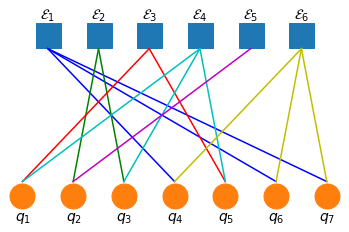

In [21]:
interaction_range_l3 = [(3,5,6),(1,2),(0,4),(0,2,4),(1,),(3,5,6)]
interaction_range_l2 = [(6,), (1,4,5), (6,), (0,3), (1,2)]
nq = 7
tanner_graph(interaction_range_l3,nq,"tanner_l3.pdf")

In [74]:
def NRWeightsPlot(percentages, xlist):
    # Plot histograms one on top of each other.
    n_rows = percentages.shape[0]
    n_cols = percentages.shape[1]
    # indices = np.arange(n_rows)
    #width = 1.0
    #sum_cumul = np.cumsum(percentages, axis=1)
    #print("cumulative shape {}\n{}".format(sum_cumul.shape, np.round(sum_cumul, 1)))
    sum_cumul = np.zeros(n_rows)
    # fig = plt.figure(figsize=(32, 22))
    for i in range(n_cols):
        plt.bar(np.arange(n_rows), percentages[:, i], width = 0.7, bottom = sum_cumul, label=i)
        sum_cumul += percentages[:,i]
    plt.ylabel('Percentage', fontsize = 24)
    plt.xlabel(r'$\alpha$', fontsize = 24)
    plt.title('Weight wise distribution of NR data')
    # plt.xticks(ind[::5], np.round(xlist,4)[::5], rotation = 45)
    plt.xticks(np.arange(n_rows), np.round(xlist, 4), rotation = 45)
    # plt.yticks(np.arange(0, 100, 25))
    plt.legend()
    plt.show() 

In [75]:
def ComputeNRBudget(nr_weights_all, alphas, nq):
    # Compute the relative budget of weight-w error rates in the NR dataset.
    n_paulis = nr_weights_all.size
    max_weight = np.max(nr_weights_all)
    n_alphas = alphas.size
    percent_errors = np.zeros((n_alphas, max_weight + 1), dtype=np.float)
    for (alpha_count, alpha) in enumerate(alphas):
        budget_pauli_count = max(int(alpha * n_paulis),1)
        nr_weights = nr_weights_all[ : budget_pauli_count]
        weights, weight_count = np.unique(nr_weights, return_counts = True)
        #print("alpha = {}\nWeights : {} and their frequencies : {} ".format(alpha, weights, weight_count))
        nerrors_weight = np.zeros(max_weight + 1, dtype = np.int)
        excess_budget = 0
        for (i, w) in enumerate(weights):
            count = weight_count[i]
            if(count > comb(nq, w) * (3 ** w)):
                nerrors_weight[w] = comb(nq, w) * (3 ** w)
                excess_budget += count - nerrors_weight[w]
            else:
                nerrors_weight[w] = count
        # Redistributing excess errors generated by Poisson distribution
        # Lower weights get priority over higher ones
        for w in range(max_weight + 1):
            need_weight_w = comb(nq, w)*(3 ** w) - nerrors_weight[w]
            add_to_weight_w = min(excess_budget, need_weight_w)
            nerrors_weight[w] += add_to_weight_w
            excess_budget -= add_to_weight_w
        percent_errors[alpha_count, :] = [nerrors_weight[w]*100/budget_pauli_count for w in range(max_weight+1)]
    return percent_errors

In [76]:
# hist_scatter(np.array([[25,25,25,25],[0,0,50,50],[100,0,0,0]]),[0,0.1,0.2])

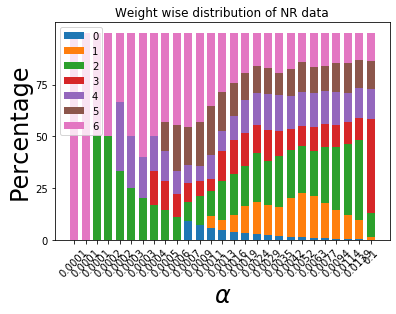

In [77]:
nq = 7
# nr_weights_l3 = np.loadtxt("/home/oem/Documents/chbank/aditya_beluga_cptp_l3_00/physical/nrw_cptp_0.07_4_8_1.5.txt").astype(int)[4]
nr_weights_l2 = np.random.randint(0, high=nq, size=(4**nq,))
alphas_l2 = np.array([0.0001,0.00012,0.00015,0.00018,0.00022,0.00027,0.00033,0.0004,0.00048,0.00059,0.00072,0.00088,0.00107,0.0013,0.00158,0.00193,0.00235,0.00287,0.00349,0.00425,0.00518,0.00631,0.00769,0.00936,0.01141,0.01389,0.1], dtype = np.float)

percentages = ComputeNRBudget(nr_weights_l2, alphas_l2, nq)
#print(np.round(percentages, 1))
hist_scatter(percentages, alphas_l2)

In [ ]:
# nr_weights_l2 = np.load("/home/oem/Documents/chbank/cptp_l2_24_12_2020_00/physical/nrw_cptp_0.03_4_8_1.5.npy").astype(int)[0]
nr_weights_l3 = np.random.randint(0, high=nq, size=(4**nq,))
alphas_l2 = [0,0.0001,0.00012,0.00015,0.00018,0.00022,0.00027,0.00033,0.0004,0.00048,0.00059,0.00072,0.00088,0.00107,0.0013,0.00158,0.00193,0.00235,0.00287,0.00349,0.00425,0.00518,0.00631,0.00769,0.00936,0.01141,0.01389,0.01693,0.02062,0.02512,0.0306,0.03728,0.04541,0.05532,0.06739,0.08209,0.1]

# percentages = get_percentages(nr_weights_l3, alphas_l3, nq)
# print("percentages\n{}".format(percentages))

hist_scatter(percentages, np.array(alphas_l3, dtype = np.float))